In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, root_mean_squared_error
from sklearn.preprocessing import MinMaxScaler


# Import the models
from sklearn.ensemble import RandomForestRegressor 
from sklearn.svm import SVR


In [97]:
# change for clean or unclean
file_name = "../data/data_with_outliers.csv"
df = pd.read_csv(file_name)
print(df.columns.tolist())

['Founded Year', 'Log_Total Funding ($M)', 'Log_Number of Employees', 'Log_Annual Revenue ($M)', 'Log_Valuation ($B)', 'Success Score', 'Acquired?', 'IPO?', 'Log_Customer Base (Millions)', 'Log_Social Media Followers', 'StartupID', 'Startup Age', 'Log_Funding per Employee', 'Log_Revenue per Employee', 'Country_Encoded', 'Funding Stage_IPO', 'Funding Stage_Seed', 'Funding Stage_Series A', 'Funding Stage_Series B', 'Funding Stage_Series C', 'Industry_AI', 'Industry_E-commerce', 'Industry_EdTech', 'Industry_Energy', 'Industry_FinTech', 'Industry_FoodTech', 'Industry_Gaming', 'Industry_Healthcare', 'Industry_Logistics', 'Industry_Tech', 'Uses_Python', 'Uses_Java', 'Uses_Nodejs', 'Uses_AI']


Building our own Success Score based on Features

In [ ]:
# Drop the old Success Score column 
df.drop(columns=['Success Score'], inplace=True)

# Creating new scores based on top features
df['Funding_Score'] = df['Log_Total Funding ($M)']
df['Customer_Score'] = df['Log_Customer Base (Millions)']
df['Efficiency_Score'] = df['Log_Funding per Employee']

# Stage Score -- higher scores to advanced stages 
df['Stage_Score'] = (
    0 * df['Funding Stage_Seed'] +
    1 * df['Funding Stage_Series A'] +
    2 * df['Funding Stage_Series B'] +
    3 * df['Funding Stage_Series C'] +
    4 * df['Funding Stage_IPO']
)

# copy aquisition status to score (1 or 0)
df['Acquired_Score'] = df['Acquired?']

# Industry score -- weighs industry by success potential 
df['Industry_Score'] = (
    df['Industry_AI'] * 1.0 +
    df['Industry_Tech'] * 0.8 +
    df['Industry_FinTech'] * 0.7 +
    df['Industry_Healthcare'] * 0.6
)

# Final weighted score 100%
# Funding = 35% 
# Stage = 20% 
# Customer size 15% 
# Aquisition status = 10% 
# Industry = 5%
df['Success Score'] = (
    0.35 * df['Funding_Score'] +
    0.2  * df['Stage_Score'] +
    0.15 * df['Customer_Score'] +
    0.15 * df['Efficiency_Score'] +
    0.1  * df['Acquired_Score'] +
    0.05 * df['Industry_Score']
)
# k fold cross validation next step -- ensure it doesnt see all the data

In [89]:
# Define features (X) and target (y)
# We drop StartupID as it's an identifier, not a predictive feature.
X = df.drop(columns=["StartupID", "Success Score"])
y = df["Success Score"]

# Calculate Mutual Information scores to find the most predictive features
mi_scores = mutual_info_regression(X, y, random_state=42)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)

# Select the top 15 features
top_features = mi_scores.sort_values(ascending=False).head(15).index.tolist()

print("Top 15 features selected based on Mutual Information:")
print(top_features)

# Create the final feature set with only the top predictors
X = X[top_features]

print(f"\nFinal feature set shape: {X.shape}")

Top 15 features selected based on Mutual Information:
['Stage_Score', 'Funding Stage_Seed', 'Funding Stage_IPO', 'Log_Total Funding ($M)', 'Funding_Score', 'Log_Funding per Employee', 'Efficiency_Score', 'Funding Stage_Series C', 'Funding Stage_Series A', 'Funding Stage_Series B', 'Log_Customer Base (Millions)', 'Customer_Score', 'Log_Revenue per Employee', 'Log_Number of Employees', 'Acquired_Score']

Final feature set shape: (5000, 15)


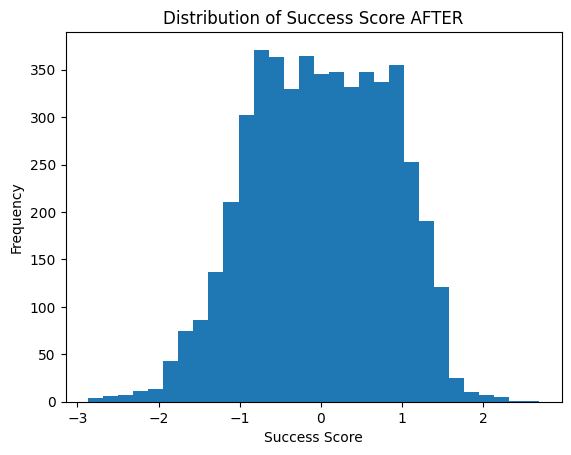

In [90]:
plt.hist(y, bins=30)
plt.title("Distribution of Success Score AFTER")
plt.xlabel("Success Score")
plt.ylabel("Frequency")
plt.show()

In [92]:
# split into 80/20 train and test split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("--- Data Split Complete ---")
print(f"Training set size: {len(X_train)} rows")
print(f"Testing set size: {len(X_test)} rows")
print("\n" + "=" * 50 + "\n")

--- Data Split Complete ---
Training set size: 4000 rows
Testing set size: 1000 rows




This is where it becomes different based on model

In [93]:
rfr = RandomForestRegressor(
    n_estimators=100, max_depth=3, random_state=42
)

# Train the model
rfr.fit(X_train, y_train)

# Make predictions on the test set
rfr_predictions = rfr.predict(X_test)

# Evaluate the model
rfr_mae = mean_absolute_error(y_test, rfr_predictions)
rfr_r2 = r2_score(y_test, rfr_predictions)
rfr_mse = mean_squared_error(y_test, rfr_predictions)
rfr_rmse = root_mean_squared_error(y_test, rfr_predictions)
print(f"Random Forest Reg MAE: {rfr_mae:.4f}")
print(f"Random Forest Reg MSE: {rfr_mse:.4f}")
print(f"Random Forest Reg R-squared: {rfr_r2:.4f}")
print(f"Random Forest Reg RMSE: {rfr_rmse:.4f}")

Random Forest Reg MAE: 0.2415
Random Forest Reg MSE: 0.1034
Random Forest Reg R-squared: 0.8501
Random Forest Reg RMSE: 0.3216


Results:

RandomForest MAE: 2.2497

RandomForest MSE: 6.6456

RandomForest R-squared: -0.0023

RandomForest RMSE: 2.5779

Feature Importance Ranking:
                         Feature  Importance
0                    Stage_Score    0.718953
1             Funding Stage_Seed    0.047208
2              Funding Stage_IPO    0.005612
3         Log_Total Funding ($M)    0.096102
4                  Funding_Score    0.091011
5       Log_Funding per Employee    0.000000
6               Efficiency_Score    0.000543
7         Funding Stage_Series C    0.004285
8         Funding Stage_Series A    0.003810
9         Funding Stage_Series B    0.032475
10  Log_Customer Base (Millions)    0.000000
11                Customer_Score    0.000000
12      Log_Revenue per Employee    0.000000
13       Log_Number of Employees    0.000000
14                Acquired_Score    0.000000


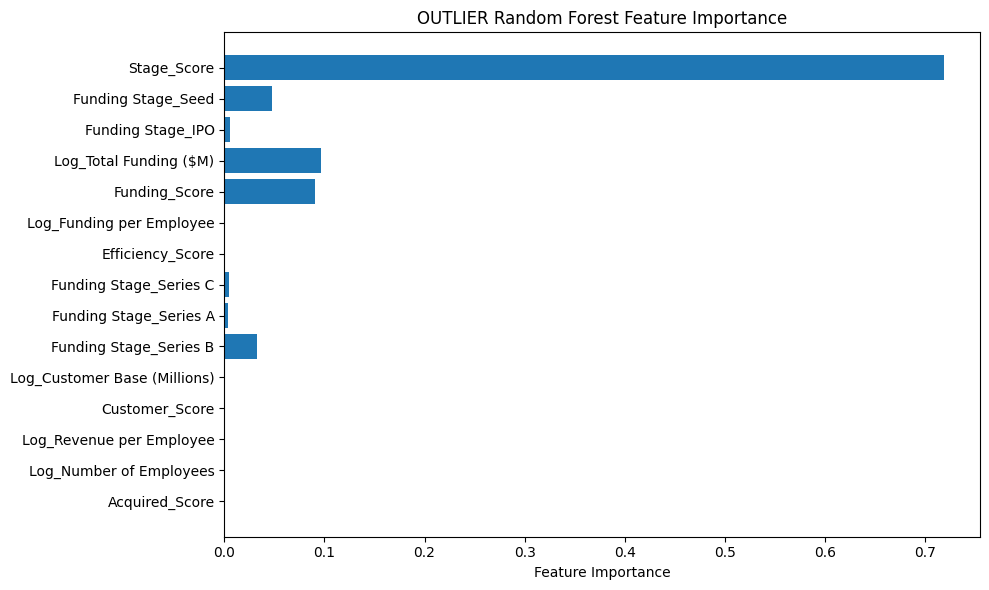

In [94]:
importances = rfr.feature_importances_
feat_imp_df = pd.DataFrame ({
    'Feature': X_train.columns,
    'Importance': importances
}) 
feat_imp_df.sort_values(by = 'Importance', ascending=False )

print("Feature Importance Ranking:")
print(feat_imp_df)

plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'])
plt.gca().invert_yaxis()  # To show the highest importance at the top
plt.xlabel('Feature Importance')
plt.title('OUTLIER Random Forest Feature Importance')
plt.tight_layout()
plt.show()